In [1]:
# import libraries
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import xgboost as xgb
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_curve,auc,precision_score,recall_score,precision_recall_curve
from sklearn.cross_validation import train_test_split

/home/shreeranga/PP/Exp/venvs/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
seed = 9999

In [3]:
# Load email data/info from csv file
emails = pd.read_csv('email_table.csv', index_col='email_id')
emails.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [4]:
emails.describe()

,hour,user_past_purchases
count,100000.000000,100000.00000
mean,9.059300,3.87845
std,4.439637,3.19611
min,1.000000,0.00000
25%,6.000000,1.00000
50%,9.000000,3.00000
75%,12.000000,6.00000
max,24.000000,22.00000


In [5]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 6 columns):
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [6]:
# feature email text has short and long paragraphs. 
# So, let's change it to numerical values. Short t0 2 and long to 4
emails['paragraphs'] = np.where(emails['email_text'] == 'short_email', 2, 4)
del emails['email_text']

In [7]:
# feature email_version has personalize (Hi, John) and generic (Hi)
emails['is_personal'] = (emails['email_version'] == 'personalized').astype(int)
del emails['email_version']

In [8]:
# map weekdays to numbers
weekdaytoindex = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
emails['weekday'] = emails['weekday'].map(weekdaytoindex)

In [9]:
# rename some of the columns to easier names
emails.rename(columns={'user_past_purchases':'purchases', 'user_country':'country'}, inplace=True)

In [10]:
emails.head()

,hour,weekday,country,purchases,paragraphs,is_personal
email_id,,,,,,
85120,2,7,US,5,2,1
966622,12,7,UK,2,4,1
777221,11,3,US,2,4,1
493711,6,1,UK,1,2,0
106887,14,1,US,6,4,0


In [11]:
# combine all the information together
emails['response'] = 'received'

open_users = pd.read_csv('email_opened_table.csv').email_id
emails.loc[open_users, 'response'] = 'opened'

clicked_users = pd.read_csv('link_clicked_table.csv').email_id
emails.loc[clicked_users, 'response'] = 'clicked'

In [12]:
emails.head()

,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,
85120,2,7,US,5,2,1,received
966622,12,7,UK,2,4,1,clicked
777221,11,3,US,2,4,1,received
493711,6,1,UK,1,2,0,received
106887,14,1,US,6,4,0,received


In [13]:
emails.to_csv('clean_emails.csv', index_label='email_id')

In [14]:
rslt = emails['response'].value_counts(normalize=True)
rslt

received    0.89605
opened      0.08276
clicked     0.02119
Name: response, dtype: float64

In [15]:
# what percentage opened the emails?
print "{: .2f}% users opened the email".format((1 - rslt['received']) * 100)

 10.39% users opened the email


In [16]:
# what percentage clicked the link?
print "{: .2f}% users clicked the link in the email".format((rslt['clicked']) * 100) 

 2.12% users clicked the link in the email


In [17]:
# Todo: exploratory data analysis

## Build the predictive model

In [18]:
X = emails.copy()
# ctr_lbl_encoder = LabelEncoder()
# X['country'] = ctr_lbl_encoder.fit_transform(X['response'])

In [19]:
X = X.loc[:,['country', 'purchases', 'paragraphs', 'is_personal']]
X['is_weekend'] = (emails['weekday'] >= 5).astype(int)
X = pd.get_dummies(X, columns=['country'], drop_first=True)
X.head()
# the targer
y = (emails['response'] == 'clicked').astype(int)

In [20]:
# split the data into training and testing
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33333,random_state = seed)
ytrain.shape

(66667,)

In [21]:
# train the model
# just gonna train one gbm model
train_matrix = xgb.DMatrix(Xtrain, ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [24]:
params = {}
params['objective'] = 'binary:logistic' # output probabilities
params['eval_metric'] = 'auc'
params['num_rounds'] = 300
params['early_stopping_rounds'] = 30
params['max_depth'] = 6
params['eta'] = 0.1
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

cv_results = xgb.cv(params, train_matrix,
                   num_boost_round=params['num_rounds'],
                   nfold = params.get('nfold', 5),
                   metrics = params['eval_metric'],
                   early_stopping_rounds=params['early_stopping_rounds'],
                   verbose_eval=True,
                   seed=seed)

[0]	train-auc:0.677493+0.00828721	test-auc:0.672627+0.00998874
[1]	train-auc:0.697782+0.00882727	test-auc:0.696658+0.0206434
[2]	train-auc:0.70463+0.00828662	test-auc:0.702561+0.0208773
[3]	train-auc:0.711914+0.00409068	test-auc:0.710696+0.0228788
[4]	train-auc:0.714488+0.00278646	test-auc:0.712043+0.0193185
[5]	train-auc:0.717649+0.00424529	test-auc:0.714465+0.0207032
[6]	train-auc:0.719344+0.00510737	test-auc:0.715544+0.0193956
[7]	train-auc:0.724209+0.00365824	test-auc:0.719632+0.0165027
[8]	train-auc:0.729045+0.00371847	test-auc:0.72386+0.0148701
[9]	train-auc:0.730501+0.00375046	test-auc:0.724429+0.0142755
[10]	train-auc:0.732467+0.0026696	test-auc:0.726337+0.0156743
[11]	train-auc:0.735537+0.00246068	test-auc:0.729132+0.0162888
[12]	train-auc:0.737188+0.00155158	test-auc:0.730848+0.0168706
[13]	train-auc:0.738333+0.00183292	test-auc:0.73156+0.016002
[14]	train-auc:0.740307+0.00175305	test-auc:0.732328+0.0157333
[15]	train-auc:0.741514+0.00256378	test-auc:0.733169+0.0154183
[16]	t

In [28]:
n_best_trees = cv_results.shape[0]
n_best_trees

53

In [29]:
watchlist = [(train_matrix, 'train')]

In [30]:
gbt = xgb.train(params, train_matrix, n_best_trees, watchlist)

[0]	train-auc:0.702188
[1]	train-auc:0.704781
[2]	train-auc:0.71018
[3]	train-auc:0.714805
[4]	train-auc:0.715547
[5]	train-auc:0.726005
[6]	train-auc:0.725821
[7]	train-auc:0.725022
[8]	train-auc:0.7335
[9]	train-auc:0.735223
[10]	train-auc:0.736723
[11]	train-auc:0.74205
[12]	train-auc:0.742289
[13]	train-auc:0.742862
[14]	train-auc:0.743885
[15]	train-auc:0.743699
[16]	train-auc:0.742109
[17]	train-auc:0.744295
[18]	train-auc:0.746087
[19]	train-auc:0.74534
[20]	train-auc:0.743896
[21]	train-auc:0.74842
[22]	train-auc:0.7502
[23]	train-auc:0.750863
[24]	train-auc:0.750096
[25]	train-auc:0.752116
[26]	train-auc:0.752202
[27]	train-auc:0.752974
[28]	train-auc:0.752529
[29]	train-auc:0.752424
[30]	train-auc:0.753932
[31]	train-auc:0.753449
[32]	train-auc:0.754669
[33]	train-auc:0.755053
[34]	train-auc:0.755589
[35]	train-auc:0.755971
[36]	train-auc:0.757188
[37]	train-auc:0.757529
[38]	train-auc:0.757631
[39]	train-auc:0.757584
[40]	train-auc:0.757568
[41]	train-auc:0.758382
[42]	train

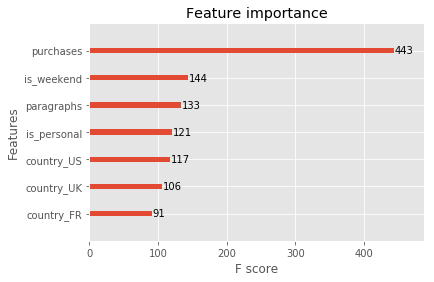

In [31]:
xgb.plot_importance(gbt)

Make sure the above results are close to finding from exploratory analysis. Yet to do that